Message Queues Example
----------------------

#### Goals
- show that client-side implementation of ordering (on top of a best-effort queue) is more efficient than using FIFO semantics, when it's possible (one consumer)
- show that dynamic "transition" from one set of semantics to the other is possible.

#### No-Negotiation Experiments

Configurations:
- client-side vs service-side implementations
- ordering semantics (BestEffort, AtMostOnce, Ordered:10, Ordered:5, Ordered:2, Ordered:1)
- message inter-arrival time (less important, probably just use 10ms)
- number of requests fixed at (say) 500?
- number of receivers: 1, 2, 5, 10

Data files should be:
`exp-{provider}-{be|ord:{0,1,2,5,10}g}-{request inter-arrival}ms-{numreceiver}rcvrs-{client|service}.data`

Missing points:
- \*-be-service and \*-be-client are the same thing
- \*-azure-ord\*-service doesn't exist
- \*-kafka-be-\* doesn't exist

#### Negotiation Experiment
- Switch from client-side to service-side after n messages (by adding another consumer), then send another n messages.
- Show latency before and after switch.

Data file:
`transition-{provider}-{request inter-arrival}ms.data`
=> include request send/receive times

In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import pandas as pd
import numpy as np

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
ords = [None, 0, 1, 2, 5, 10]
provs = ['aws', 'gcp', 'azure', 'kafka']
inters = [0, 25, 50, 75, 100]
receivers = [1, 2, 5, 10]
impls = ['client', 'service']

In [3]:
exp_dir = "exp-round-2"

In [4]:
df = None
for m in impls:
    for p in provs:
        for i in inters:
            for o in ords:
                o =  'be' if o is None else f"ord:{o}g"
                for r in receivers:
                    if m == 'client' and r > 1:
                        continue
                    file = f"{exp_dir}/exp-{p}-{o}-{i}ms-{r}rcvrs-{m}.data"
                    try:
                        file_df = pd.read_csv(file, sep=" ")
                        file_df['impl'] = m
                        file_df['num_receivers'] = r
                        if 'exp' in file_df:
                            del file_df['exp']
                        if 'req_orderedness' in file_df:
                            del file_df['req_orderedness']
                        if df is None:
                            df = file_df
                        else:
                            df = df.append(file_df)
                    except:
                        continue

df

,mode,provider,inter_request_ms,num_msgs,elapsed_us,msg_send_time,req_latency_us,impl,num_receivers
0,BestEffort,aws,0,100,1486920,19,33631,client,1
1,BestEffort,aws,0,100,1486920,26520,46658,client,1
2,BestEffort,aws,0,100,1486920,62040,38420,client,1
3,BestEffort,aws,0,100,1486920,104102,11823,client,1
4,BestEffort,aws,0,100,1486920,119340,18063,client,1
...,...,...,...,...,...,...,...,...,...
95,Ordered:10,kafka,100,100,10483364,10178050,6277,service,10
96,Ordered:10,kafka,100,100,10483364,10284839,6145,service,10
97,Ordered:10,kafka,100,100,10483364,10391474,5938,service,10
98,Ordered:10,kafka,100,100,10483364,10499032,6176,service,10


In [8]:
df.to_csv("./msg-queue-latencies.csv")

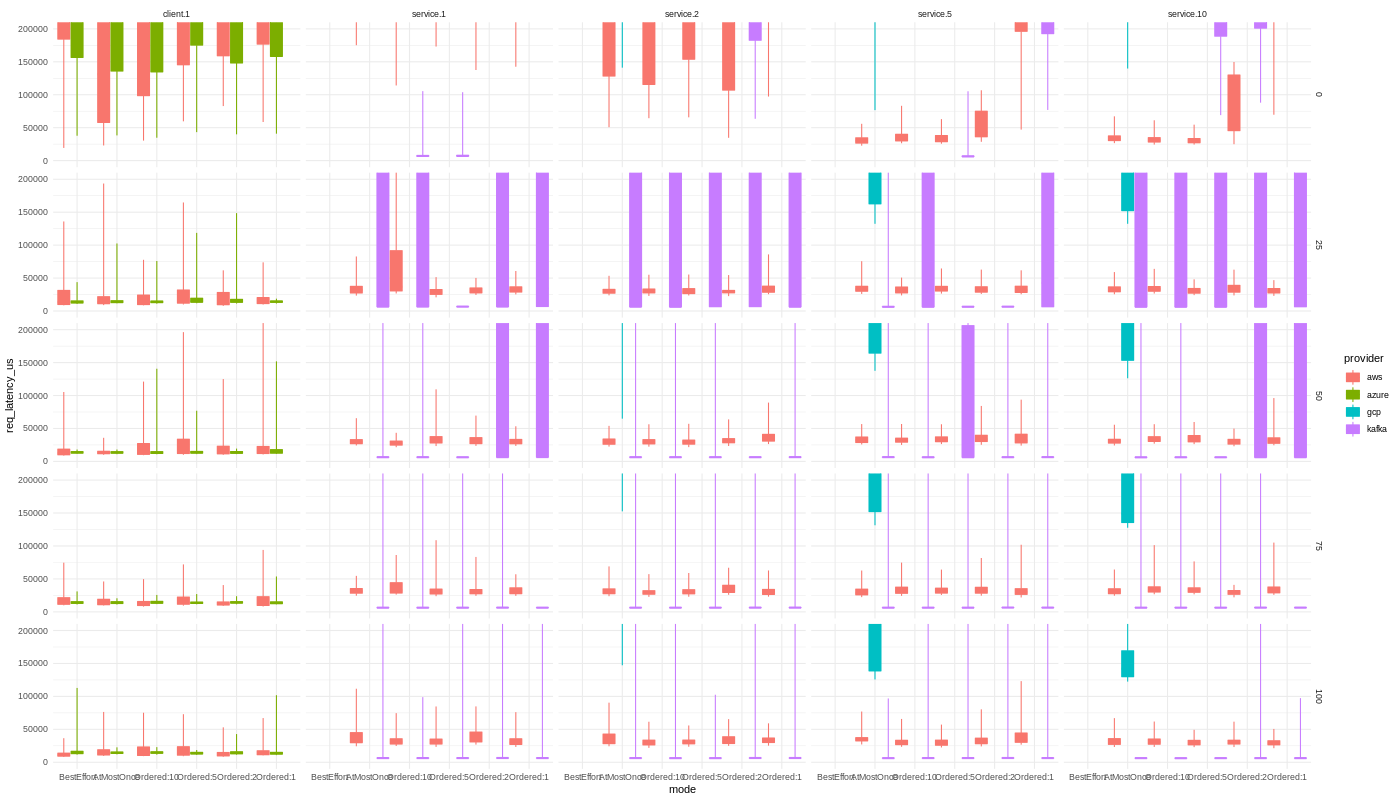

In [5]:
%%R -i df -w 1400 -h 800

library(ggplot2)

f <- function(x) {
  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

ggplot(df, aes(x=mode, 
    y=req_latency_us, 
    fill=provider, colour=provider)) + 
  stat_summary(fun.data = f, geom="boxplot", position=position_dodge(width=1)) + 
  facet_grid(inter_request_ms ~ interaction(impl, num_receivers)) + 
  coord_cartesian(ylim=c(0, 200e3)) +
  scale_x_discrete(limits = c("BestEffort", "AtMostOnce", "Ordered:10", "Ordered:5", "Ordered:2", "Ordered:1")) +
  theme_minimal()


In [6]:
neg_df = pd.read_csv(f"{exp_dir}/transition-25ms-aws-ord5g.data", sep=" ")
neg_df

,mode,provider,inter_request_ms,num_msgs,elapsed_us,msg_send_time,req_latency_us,req_orderedness
0,Ordered:5,aws,25,200,0,418,45473,0.0
1,Ordered:5,aws,25,200,0,53848,20685,0.0
2,Ordered:5,aws,25,200,0,95479,27110,0.0
3,Ordered:5,aws,25,200,0,148002,11724,0.0
4,Ordered:5,aws,25,200,0,181198,11413,0.0
...,...,...,...,...,...,...,...,...
195,Ordered:5,aws,25,200,0,7652951,25994,0.0
196,Ordered:5,aws,25,200,0,7690934,32642,0.0
197,Ordered:5,aws,25,200,0,7727530,26665,0.0
198,Ordered:5,aws,25,200,0,7764347,31731,0.0


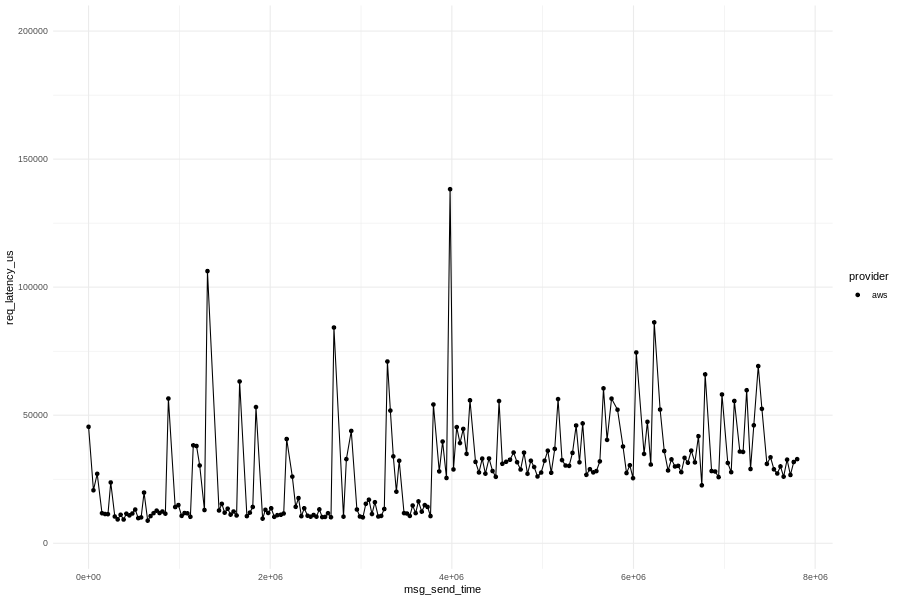

In [7]:
%%R -i neg_df -w 900 -h 600

library(ggplot2)
ggplot(neg_df, aes(x=msg_send_time, 
    y=req_latency_us, 
    fill=provider)) + 
  geom_line() + geom_point() +
  coord_cartesian(ylim=c(0, 200e3)) +
  theme_minimal()